<img src='pics/otus.png'>

In [411]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
# import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 50)


In [412]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score


## 0. Рассматриваем "Breast Cancer Wisconsin (Diagnostic) Data Set"

In [413]:
df_source = pd.read_csv(r'data.csv') #/Users/mary/Desktop/Otus/Module 2/L15. PCA, T-sne/data.csv
df=df_source
df.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.00,0.12,0.28,0.30,0.15,0.24,0.08,1.09,0.91,8.59,153.40,0.01,0.05,0.05,0.02,0.03,0.01,25.38,17.33,184.60,2019.00,0.16,0.67,0.71,0.27,0.46,0.12,nan
1,842517,M,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,0.18,0.06,0.54,0.73,3.40,74.08,0.01,0.01,0.02,0.01,0.01,0.00,24.99,23.41,158.80,1956.00,0.12,0.19,0.24,0.19,0.28,0.09,nan
2,84300903,M,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,0.21,0.06,0.75,0.79,4.58,94.03,0.01,0.04,0.04,0.02,0.02,0.00,23.57,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09,nan


# 1. EDA
Просмотреть структуру данных, значения каждого признака, поискать особенности в признаках и в данных в целом

In [414]:
df.shape

(569, 33)

In [365]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

Уже из полученной информации можем убрать столбец Unnamed:32, поскольку в нем нигде нет значений. И теперь пропуски можем не обрабатывать, т.к. их нет. Также, присутствует фича типа "объект" - диагноз: M = malignant (признак злокачественности опухоли), B = benign (признак доброкачественности). Это таргет переменная:

In [366]:
df.groupby('diagnosis')['id'].count()

diagnosis
B    357
M    212
Name: id, dtype: int64

Классы сбаллансированны. В выборке примерно 60% одгоно и 40% другого классов

In [305]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,0.00
mean,30371831.43,14.13,19.29,91.97,654.89,0.10,0.10,0.09,0.05,0.18,0.06,0.41,1.22,2.87,40.34,0.01,0.03,0.03,0.01,0.02,0.00,16.27,25.68,107.26,880.58,0.13,0.25,0.27,0.11,0.29,0.08,nan
std,125020585.61,3.52,4.30,24.30,351.91,0.01,0.05,0.08,0.04,0.03,0.01,0.28,0.55,2.02,45.49,0.00,0.02,0.03,0.01,0.01,0.00,4.83,6.15,33.60,569.36,0.02,0.16,0.21,0.07,0.06,0.02,nan
min,8670.00,6.98,9.71,43.79,143.50,0.05,0.02,0.00,0.00,0.11,0.05,0.11,0.36,0.76,6.80,0.00,0.00,0.00,0.00,0.01,0.00,7.93,12.02,50.41,185.20,0.07,0.03,0.00,0.00,0.16,0.06,nan
25%,869218.00,11.70,16.17,75.17,420.30,0.09,0.06,0.03,0.02,0.16,0.06,0.23,0.83,1.61,17.85,0.01,0.01,0.02,0.01,0.02,0.00,13.01,21.08,84.11,515.30,0.12,0.15,0.11,0.06,0.25,0.07,nan
50%,906024.00,13.37,18.84,86.24,551.10,0.10,0.09,0.06,0.03,0.18,0.06,0.32,1.11,2.29,24.53,0.01,0.02,0.03,0.01,0.02,0.00,14.97,25.41,97.66,686.50,0.13,0.21,0.23,0.10,0.28,0.08,nan
75%,8813129.00,15.78,21.80,104.10,782.70,0.11,0.13,0.13,0.07,0.20,0.07,0.48,1.47,3.36,45.19,0.01,0.03,0.04,0.01,0.02,0.00,18.79,29.72,125.40,1084.00,0.15,0.34,0.38,0.16,0.32,0.09,nan
max,911320502.00,28.11,39.28,188.50,2501.00,0.16,0.35,0.43,0.20,0.30,0.10,2.87,4.88,21.98,542.20,0.03,0.14,0.40,0.05,0.08,0.03,36.04,49.54,251.20,4254.00,0.22,1.06,1.25,0.29,0.66,0.21,nan


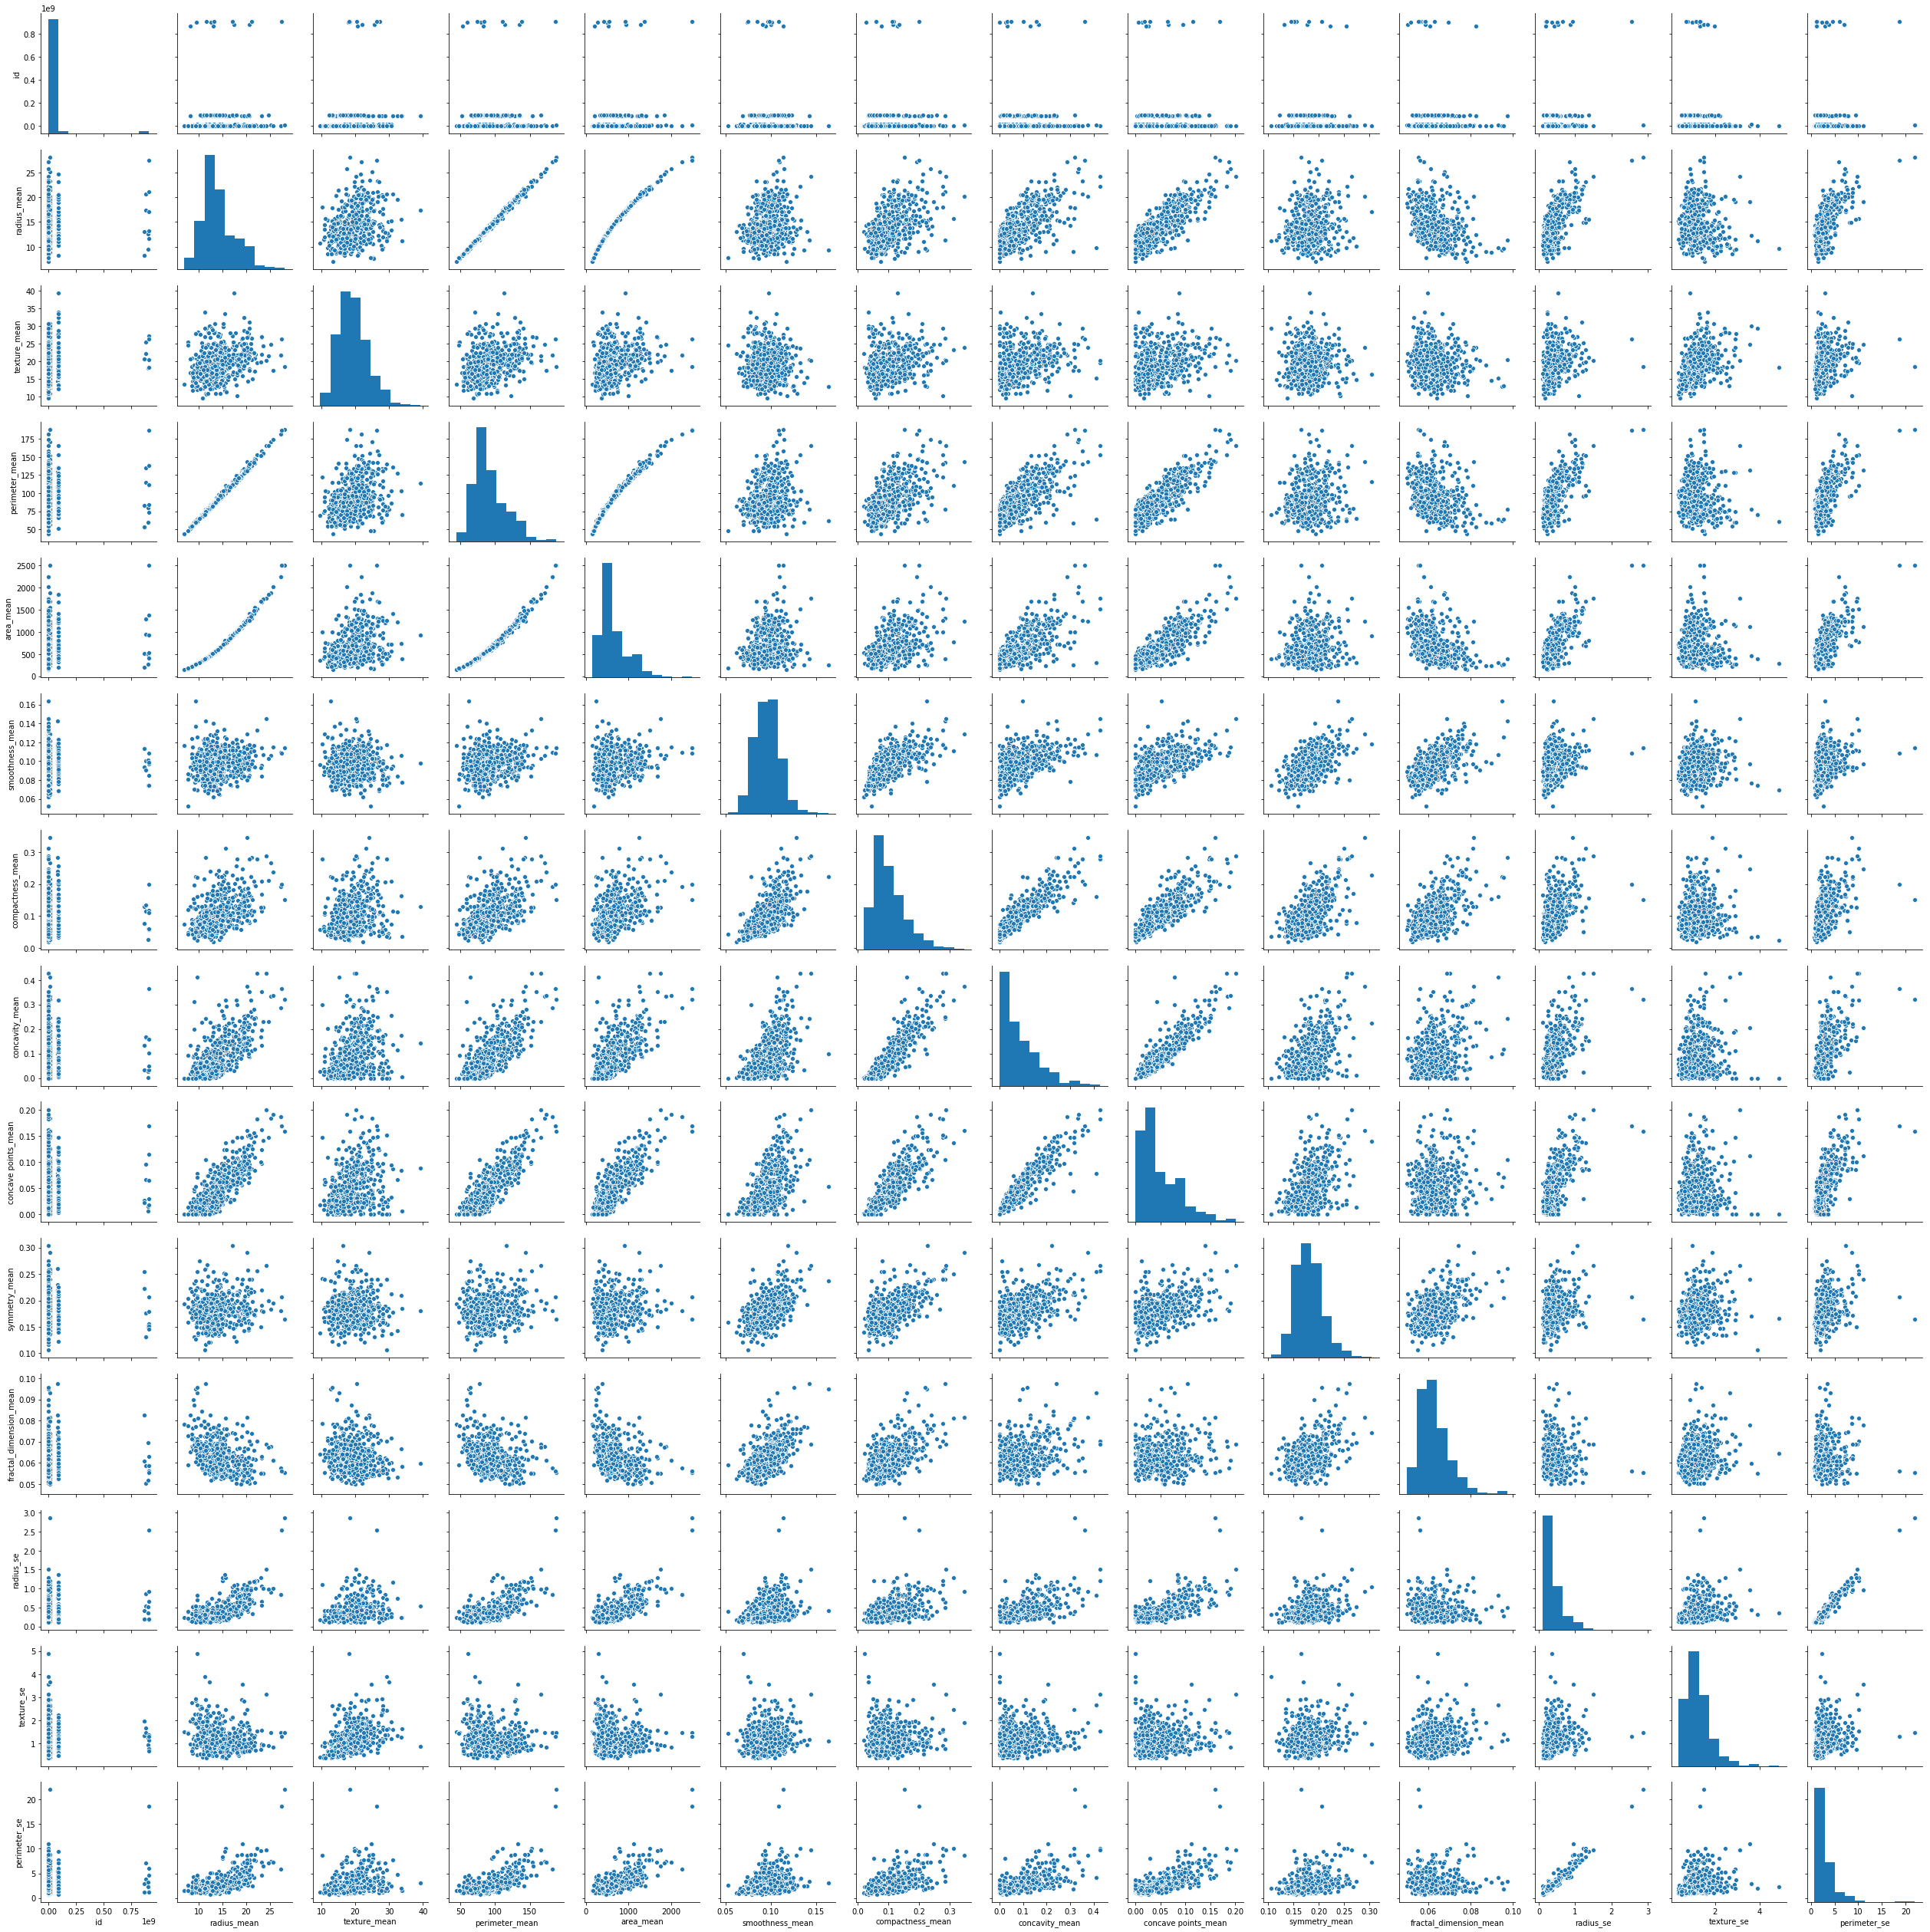

In [306]:
sns.pairplot(df.iloc[:, :15])

Поскольку фич много, pairplot смотреть неудобно уже для 15 фич, но четкая зависимость между некоторыми из них уже видна. Посмотрим на наличие линейной зависимости на тепловой карте

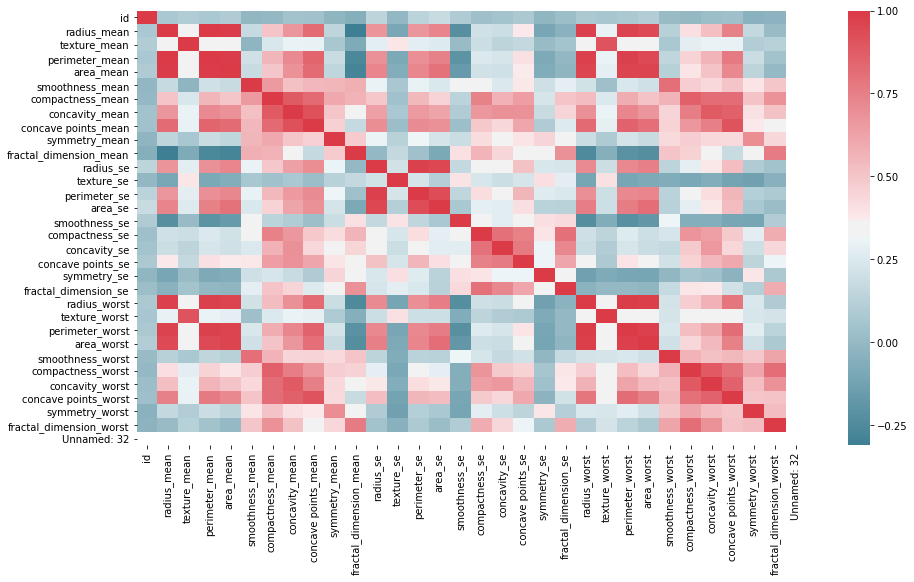

In [307]:
sns.heatmap(df.corr(),annot=False, cmap=sns.diverging_palette(220, 10, as_cmap=True));

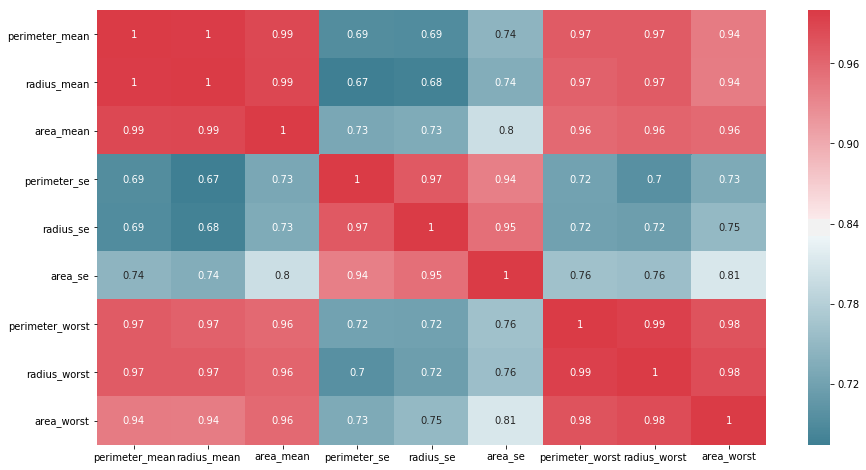

In [308]:
sns.heatmap(df[['perimeter_mean', 
                'radius_mean', 
                'area_mean',
                'perimeter_se', 
                'radius_se', 
                'area_se', 
                'perimeter_worst', 
                'radius_worst', 
                'area_worst']].corr()
            ,annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True)
           );

Между некоторыми фичами есть сильная корреляция (например: area, radius, perimeter - worst, se и mean), что значит, что часть из этих фич желательно убрать, либо преобразовать

(569, 13)


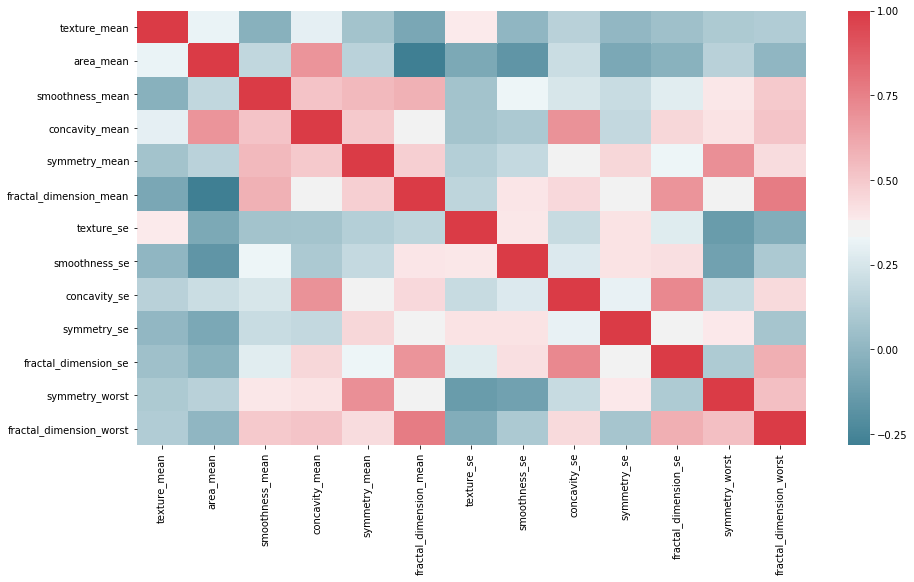

In [415]:
experiment = df.drop(['Unnamed: 32', 
                    'id', 
                     'diagnosis', 
                     'perimeter_mean', 
                     'radius_mean',
                     'perimeter_se', 
                     'radius_se', 
                     'area_se', 
                     'perimeter_worst', 
                     'radius_worst', 
                     'area_worst',
                    'concave points_mean', 
                    'compactness_mean', 
                    'concave points_worst', 
                    'compactness_worst', 
                    'concavity_worst', 
                    'compactness_se', 
                    'concave points_se',
                    'smoothness_worst',
                    'texture_worst'
                   ], axis=1)
sns.heatmap(experiment.corr(),annot=False, cmap=sns.diverging_palette(220, 10, as_cmap=True));
print(experiment.shape)

# 2. План эксперимента 


* Применить Encoder к признаку "диагноз", отнормировать признаки
* Убрать сильно коррелирующие признаки, добавить полиномиальные
* Применить понижение размерности для визуализации данных (TSNE)
* Применить кластеризацию, визуализировать
* Описание кластера
* Любые другие пункты

# 3. Подготовка данных для построения модели


Уберем из признаков полностью нулевой столбец 'Unnamed: 32', поскольку он не несет никакой информации. 

Также уберем корреллирующие признаки.

In [416]:
diagnosis = df['diagnosis']
features = df.drop(['Unnamed: 32', 
                    'id', 
                     'diagnosis', 
                     'perimeter_mean', 
                     'radius_mean',
                     'perimeter_se', 
                     'radius_se', 
                     'area_se', 
                     'perimeter_worst', 
                     'radius_worst', 
                     'area_worst',
                    'concave points_mean', 
                    'compactness_mean', 
                    'concave points_worst', 
                    'compactness_worst', 
                    'concavity_worst', 
                    'compactness_se', 
                    'concave points_se',
                    'smoothness_worst',
                    'texture_worst'
                   ], axis=1)

features_all = df.drop(['Unnamed: 32', 'id', 'diagnosis'], axis=1)

diagnosis = LabelEncoder().fit_transform(diagnosis)
features = StandardScaler().fit_transform(features)
features = PolynomialFeatures().fit_transform(features)

features_all = StandardScaler().fit_transform(features_all)
features_all = PolynomialFeatures().fit_transform(features_all)


In [417]:
features.shape, features_all.shape

((569, 105), (569, 496))

# 4. Построение модели 

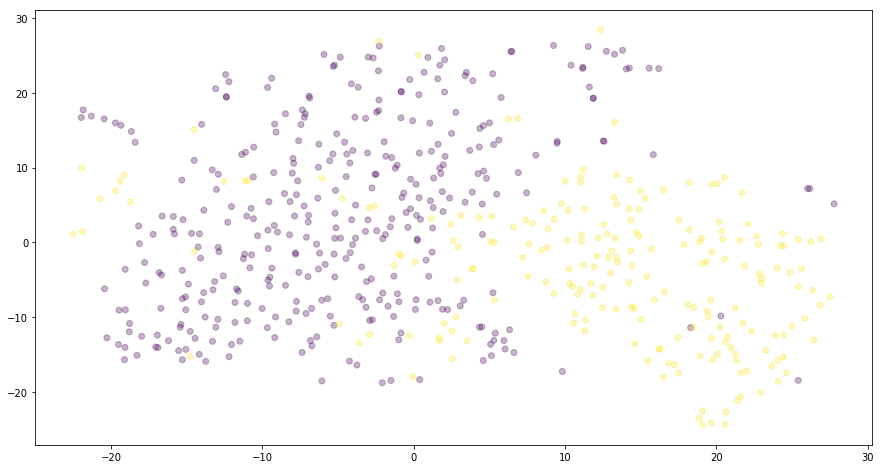

In [370]:
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(features)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=diagnosis, alpha=0.3);

В целом, видно, что разделение на классы прошло хорошо: классы разделимы (с некоторым зашумлением)

In [418]:
x_train, x_test, y_train, y_test = train_test_split(features, diagnosis, test_size=0.3, random_state=45)

In [419]:
lr = LogisticRegressionCV(cv=5, max_iter = 500, random_state=45)
lr.fit(x_train, y_train)
simple_pred = lr.predict(x_test)

In [420]:
print(roc_auc_score(simple_pred, y_test))
print(average_precision_score(simple_pred, y_test))
print(precision_score(simple_pred, y_test))
print(recall_score(simple_pred, y_test))

0.9782608695652174
0.9180327868852459
0.9180327868852459
1.0


Бейзлайн модель построена, теперь попробуем уменьшить размерность при помощи PCA

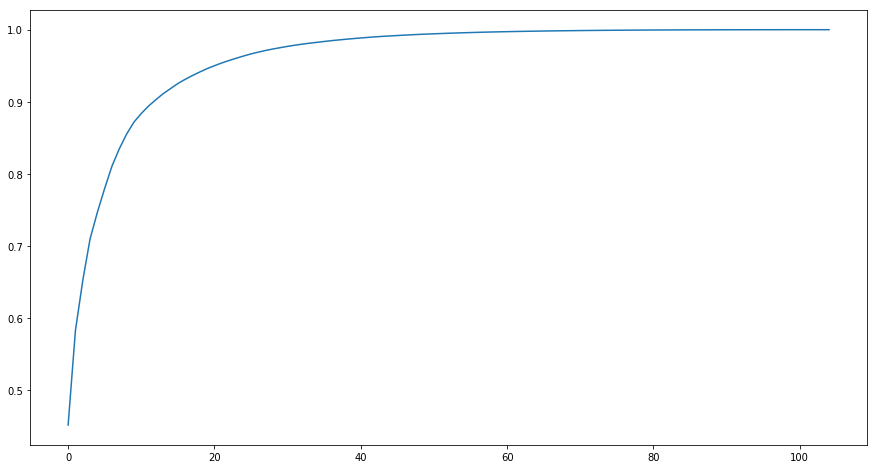

In [421]:
pca = PCA(random_state=45)
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum);

In [422]:
print(features_all.shape)
print(np.argmax(cumsum >= 0.99) + 1)
print(np.argmax(cumsum >= 0.95) + 1)

(569, 496)
43
22


Из графика видим, что достаточно взять 43 признаков из 496, чтобы объяснить 99% дисперсии данных и 22 для 95%. Посмотрим на результаты проверки качества в обоих случаях:

In [428]:
pca_99 = PCA(43, random_state=45)
pca_99.fit(x_train)
lr_99 = LogisticRegressionCV(cv=5, max_iter = 500, random_state=45)
lr_99.fit(x_train, y_train)
lr_99_pred = lr_99.predict(x_test)

pca_95 = PCA(22, random_state=45)
pca_95.fit(x_train)
lr_95 = LogisticRegressionCV(cv=5, max_iter = 500, random_state=45)
lr_95.fit(x_train, y_train)
lr_95_pred = lr_95.predict(x_test)

for i in [lr_99_pred, lr_95_pred]:
    print(roc_auc_score(i, y_test))
    print(average_precision_score(i, y_test))
    print(precision_score(i, y_test))
    print(recall_score(i, y_test))
    print()

0.9782608695652174
0.9180327868852459
0.9180327868852459
1.0

0.9782608695652174
0.9180327868852459
0.9180327868852459
1.0



Данный результат идентичен бейзлайну и посчитан для уже ранее отобранных признаков, посмотрим аналогичную информацию на исходных данных:

(569, 496)
61
27


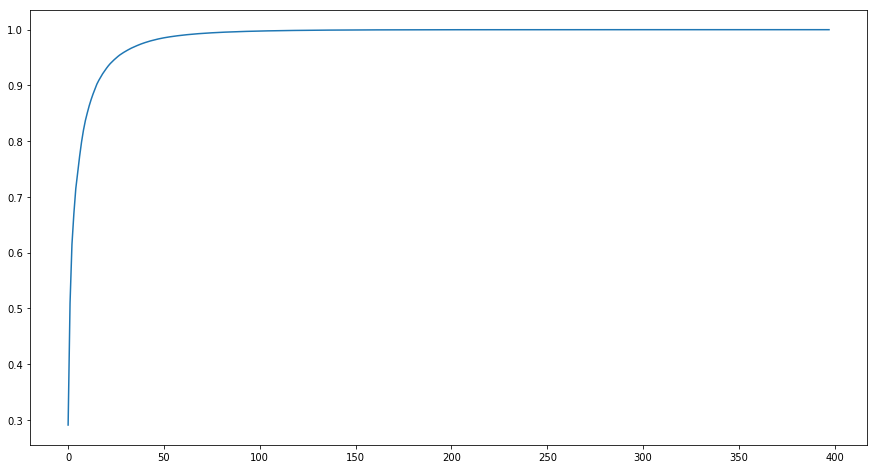

In [424]:
x_train, x_test, y_train, y_test = train_test_split(features_all, diagnosis, test_size=0.3, random_state=45)

pca = PCA(random_state=45)
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum);

print(features_all.shape)
print(np.argmax(cumsum >= 0.99) + 1)
print(np.argmax(cumsum >= 0.95) + 1)

Для исходных данных получили, что 61 признак объяснит 99% дисперсии данных, а 27 признаков 95%. Проведем эксперимент и построим модель для первого случая и для варианта, когда отобран только 1 самый важный признак

In [425]:
pca_origin_99 = PCA(61, random_state=45)
pca_origin_99.fit(x_train)
lr_origin_99 = LogisticRegressionCV(cv=5, max_iter = 500, random_state=45)
lr_origin_99.fit(x_train, y_train)
lr_origin_99_pred = lr_origin_99.predict(x_test)

# pca_origin_95 = PCA(27, random_state=45)
# pca_origin_95.fit(x_train)
# lr_origin_95 = LogisticRegressionCV(cv=5, max_iter = 500, random_state=45)
# lr_origin_95.fit(x_train, y_train)
# lr_origin_95_pred = lr_origin_95.predict(x_test)

pca_origin_1 = PCA(1, random_state=45)
pca_origin_1.fit(x_train)
lr_origin_1 = LogisticRegressionCV(cv=5, max_iter = 500, random_state=45)
lr_origin_1.fit(x_train, y_train)
lr_origin_1_pred = lr_origin_1.predict(x_test)

for i in [lr_origin_99_pred, lr_origin_1_pred]:
    print(roc_auc_score(i, y_test))
    print(average_precision_score(i, y_test))
    print(precision_score(i, y_test))
    print(recall_score(i, y_test))
    print()

0.9781325665859564
0.940552037684282
0.9508196721311475
0.9830508474576272

0.9781325665859564
0.940552037684282
0.9508196721311475
0.9830508474576272



# 5. Проанализировать результат
